In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [7]:
train_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_train.csv', index_col=0)
test_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test1.csv', index_col=0)
submit1_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test2.csv', index_col=0)
submit2_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test3.csv', index_col=0)
df_school = pd.read_csv('school_data.csv',index_col=0)


train_df = train_df.drop(train_df[(train_df['size_sqft']>8000)& (train_df['rent']<10000)].index).reset_index(drop=True)

train_df = train_df.drop(train_df[(train_df['bathrooms']>=12) 
                         & (train_df['rent']<10000)].index).reset_index(drop=True)

train_df = train_df.drop(train_df[(train_df['bathrooms']==6) 
                         & (train_df['rent']<20000)].index).reset_index(drop=True)


train_df = train_df.drop(train_df[(train_df['bedrooms']>=8) 
                         & (train_df['rent']<20000)].index).reset_index(drop=True)

cf = submit1_df #retaining the dataframe in cf instead incase I want to look at the original without edits
cf.min_to_subway = cf.min_to_subway.fillna(cf.min_to_subway.mean(), axis=0) #Replacing empty values with the mean of the entire column
cf.year_built = cf.year_built.fillna(cf.year_built.median(), axis=0) #Replacing empty values with the median of the entire column


In [8]:
train_df = pd.merge(train_df,df_school, left_on='addr_zip', right_on='zipcode')

train_df

,addr_unit,building_id,bedrooms,bathrooms,size_sqft,created_at,addr_street,addr_city,addr_zip,addr_lat,...,has_childrens_playroom,rent,no_fee,description,neighborhood,borough,unit,floornumber,line,Occurrences
0,#22A,551248,4,3.0,1300.0,2018-06-04 16:31:06,645 OCEAN AVENUE,Brooklyn,11226,40.646982,...,0,3925,1,MAGNIFICENT GUT RENOVATED 4 BEDROOM 3 BATHROOM...,Flatbush,Brooklyn,22A,NaN,NaN,5
1,#B23,548233,1,1.0,800.0,2018-07-01 12:15:36,199 LINDEN BOULEVARD,Brooklyn,11226,40.653070,...,0,1645,0,+ Large Apartment\r\n+ New Kitchen\r\n+ King S...,Flatbush,Brooklyn,B23,NaN,NaN,5
2,#6G,559180,1,1.0,750.0,2018-06-28 16:29:30,585 EAST 21 STREET,Brooklyn,11226,40.639518,...,0,1650,1,"NO FEE\r\n\r\nYour new dream rental, is a real...",Ditmas Park,Brooklyn,6G,6.0,G,5
3,#1P,18771592,0,1.0,492.0,2018-05-04 16:04:18,125 PARKSIDE AVENUE,Brooklyn,11226,40.653500,...,1,2250,1,Advertised rent reflects a net rent of 2 month...,Prospect Park South,Brooklyn,1P,1.0,P,5
4,#2C,555277,1,1.0,785.0,2018-06-21 08:03:18,330 EAST 22 STREET,Brooklyn,11226,40.643847,...,0,1895,0,NO FEE!!!!\r\nNewly renovated 1 bedroom in Dit...,Flatbush,Brooklyn,2C,2.0,C,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9421,#3D,1151395,1,1.0,750.0,2018-06-21 10:58:32,3333 BRUNER AVENUE,Bronx,10469,40.876993,...,0,1450,0,"Very Spacious and Sunny, Private Terrace, Dish...",Laconia,Bronx,3D,3.0,D,5
9422,#2,2280460,2,1.0,776.0,2018-05-21 15:11:01,158 HAGAMAN PLACE,Staten Island,10302,40.626530,...,0,1900,0,Showing by appointments only!\r\n\r\n2 Bedroom...,Port Richmond,Staten Island,2,2.0,NaN,1
9423,#19,1083148,1,1.0,725.0,2018-05-09 15:49:39,1427 TAYLOR AVENUE,Bronx,10460,40.835976,...,0,1450,0,Spacious Totally Renovated One Bedroom \r\n\r\...,Parkchester,Bronx,19,NaN,NaN,5
9424,#30,1083148,1,1.0,750.0,2018-06-01 15:38:15,1427 TAYLOR AVENUE,Bronx,10460,40.835976,...,0,1450,0,This unique and gut renovated apartment featur...,Parkchester,Bronx,30,NaN,NaN,5


#### Build training data

In [36]:

feature_cols = [
    'bedrooms', 'year_built', 'bathrooms', 'min_to_subway', 
    'size_sqft', 'no_fee', 'has_doorman'
]
train_features = train_df[feature_cols] 

# impute missing values with medians
train_features = train_features.fillna(train_features.median(), axis=0)

# construct target vector
train_target = train_df['rent']

#### Fit model

In [37]:
lreg = LinearRegression()
lreg.fit(train_features, train_target)

rf = RandomForestRegressor()
rf.fit(train_features, train_target)

C:\Users\monke\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

#### Predict and Measure Using Test 1

In [38]:
test_features = test_df[feature_cols] 

# impute missing values with medians
test_features = test_features.fillna(train_features.median(), axis=0)

# construct predictions 
test_df['predicted'] = lreg.predict(test_features)

mean_squared_error(test_df['rent'], test_df['predicted'])

3839045.0896849376

#### Combine Data, Predict Values for Test 2

In [39]:
master_df = train_df.append(test_df, sort=False)

master_features = master_df[feature_cols].fillna(master_df[feature_cols].median(), axis=0)
master_target = master_df['rent']

rf.fit(master_features, master_target)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [175]:
train_df.corr() #Looking at which features correlate the most with the rent from the training data

,building_id,bedrooms,bathrooms,size_sqft,addr_zip,addr_lat,addr_lon,bin,bbl,floor_count,year_built,min_to_subway,has_doorman,has_elevator,has_fireplace,has_dishwasher,is_furnished,has_gym,allows_pets,has_washer_dryer,has_garage,has_roofdeck,has_concierge,has_pool,has_garden,has_childrens_playroom,rent,no_fee,floornumber
building_id,1.000000,-0.001813,-0.016501,-0.006433,0.064199,-0.008653,0.105315,0.117460,0.090194,-0.116488,0.026593,-0.006980,-0.042830,0.061696,-0.031611,0.023323,-0.012521,0.004550,0.040899,-0.030651,0.099141,-0.012773,-0.060398,0.038340,0.064100,0.011357,-0.035145,0.052429,-0.003418
bedrooms,-0.001813,1.000000,0.464287,0.525537,0.187639,-0.114986,0.093089,0.142331,0.151078,-0.228858,-0.056614,0.014171,-0.233059,-0.278231,0.049998,0.046002,-0.046021,-0.206094,0.023819,0.117120,-0.116837,-0.085111,-0.202524,-0.091116,0.048234,-0.083456,0.353337,-0.004335,-0.158895
bathrooms,-0.016501,0.464287,1.000000,0.565788,-0.088524,0.028441,-0.062992,-0.100642,-0.106358,0.091489,-0.004480,0.017966,0.108987,0.095867,0.124532,0.161132,0.050068,0.113062,0.087348,0.298722,0.051650,0.102592,0.105276,0.089527,0.104741,0.111949,0.611987,-0.003053,0.116938
size_sqft,-0.006433,0.525537,0.565788,1.000000,0.000576,-0.037717,-0.035054,-0.013148,-0.011608,0.020547,-0.021524,0.007718,0.047766,0.029836,0.155044,0.111761,0.041965,0.022605,0.032325,0.263907,0.005959,0.026781,0.040962,0.051020,0.137652,0.068867,0.649984,-0.074162,0.054328
addr_zip,0.064199,0.187639,-0.088524,0.000576,1.000000,-0.577385,0.462277,0.950995,0.952018,-0.447352,-0.004916,0.023660,-0.410034,-0.362939,-0.072233,-0.166108,-0.135857,-0.287916,-0.115378,-0.113234,-0.116047,-0.107670,-0.354300,-0.193333,-0.006699,-0.162588,-0.325241,-0.066025,-0.376063
addr_lat,-0.008653,-0.114986,0.028441,-0.037717,-0.577385,1.000000,0.219029,-0.429858,-0.424711,0.195647,-0.002415,-0.026215,0.191486,0.167685,0.019505,0.078029,0.054610,0.115376,0.015503,0.013967,0.057687,-0.000782,0.146865,0.104243,0.000178,0.066387,0.109536,0.002401,0.170598
addr_lon,0.105315,0.093089,-0.062992,-0.035054,0.462277,0.219029,1.000000,0.554511,0.563806,-0.281790,-0.003623,-0.012528,-0.259673,-0.182011,-0.070451,-0.138343,-0.085478,-0.224737,-0.153365,-0.165555,-0.055615,-0.168426,-0.270704,-0.100606,-0.038981,-0.140828,-0.262711,-0.041091,-0.239193
bin,0.117460,0.142331,-0.100642,-0.013148,0.950995,-0.429858,0.554511,1.000000,0.994155,-0.426813,0.010451,0.021091,-0.380284,-0.326176,-0.084767,-0.173532,-0.131706,-0.263453,-0.144695,-0.119801,-0.089042,-0.112548,-0.323696,-0.182156,-0.007928,-0.144938,-0.332165,-0.111486,-0.350957
bbl,0.090194,0.151078,-0.106358,-0.011608,0.952018,-0.424711,0.563806,0.994155,1.000000,-0.442496,0.005694,0.015880,-0.403373,-0.351657,-0.081656,-0.185248,-0.132950,-0.292240,-0.160086,-0.137143,-0.109457,-0.135245,-0.346828,-0.193851,-0.021434,-0.169315,-0.339157,-0.126716,-0.367065
floor_count,-0.116488,-0.228858,0.091489,0.020547,-0.447352,0.195647,-0.281790,-0.426813,-0.442496,1.000000,0.151318,-0.011722,0.664202,0.560443,-0.024808,0.229530,0.112042,0.633673,0.205669,0.177199,0.380581,0.361168,0.655252,0.498138,0.084536,0.395460,0.253517,0.185316,0.769707


#### Create Submission File for `test2`

In [40]:
submit1_features = cf[feature_cols].fillna(master_df[feature_cols].median(), axis=0)
cf['predictions'] = rf.predict(submit1_features) 
cf['predictions'].to_csv('sample_submission1.csv', header=True)

cf['fake_rent'] = np.ones(cf['predictions'].shape) * master_target.median()
mean_squared_error(cf['predictions'], cf['fake_rent'])

6929159.569303347

In [41]:

test = cf.sort_values(['predictions'], ascending=[1])
print(test)

          addr_unit  building_id  bedrooms  bathrooms  size_sqft  \
rental_id                                                          
7448224        #3RE     18715399         0        1.0      450.0   
7505419         #4F       741634         0        1.0      500.0   
7518319         #14     17966671         0        1.0      375.0   
7476610        #3DD       812170         0        1.0      500.0   
7431439         #E2       812170         0        1.0      500.0   
7467190        #1FF       219199         0        1.0      250.0   
7459297        #1AA       219199         0        1.0      250.0   
7467187        #1FF       219199         0        1.0      250.0   
7430536        #612      1606783         0        1.0      500.0   
7512829       #612A      1606783         0        1.0      500.0   
7474213        #A23       701578         1        1.0      500.0   
7506694        #4/F     18356584         0        1.0      595.0   
7487050        #C32       638848         1      

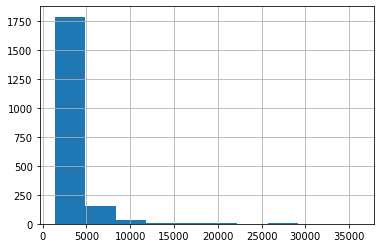

In [46]:
test['predictions'].hist() #Confirming largest predicted rent is 15516 visually. As expected we see that there are more apartments ranging from 2k-3k than any other price range.

#### Create Submission File for `test3`

In [44]:
submit2_features = submit2_df[feature_cols].fillna(master_df[feature_cols].median(), axis=0)
submit2_df['predictions'] = rf.predict(submit2_features)
submit2_df['predictions'].to_csv('sample_submission2.csv', header=True)

submit2_df['fake_rent'] = np.ones(submit2_df['predictions'].shape) * master_target.median()
mean_squared_error(submit2_df['predictions'], submit2_df['fake_rent'])

5560330.031567476

In [45]:
test = submit2_df.sort_values(['predictions'], ascending=[1])
print(test)

          addr_unit  building_id  bedrooms  bathrooms  size_sqft  \
rental_id                                                          
7448083         #4C      1279153         0        1.0      395.0   
7485349         #1D     18532186         0        1.0      420.0   
7485346         #1D     18532186         0        1.0      420.0   
7470511         #E1     18339034         0        1.0      500.0   
7518895         #2C        51991         0        1.0      450.0   
7510405         #1A      1870690         0        1.0      600.0   
7495531         #1J      2190883         1        1.0      600.0   
7481896        #634      1677385         0        1.0      595.0   
7513057        #C11     18271939         1        1.0      700.0   
7472128        #712      1606783         0        1.0      500.0   
7444318          #2      1304740         1        1.0      500.0   
7509406       #634A      1677385         0        1.0      610.0   
7486999        #D23       673036         1      